# Стратегии Alignment: DPO vs PPO

В этой домашке поближе познакомимся с двумя крайне популярными методами алаймента языковых моделей. В первой части вам предоставится возможность самостоятельно заимплементить DPO c нуля. Во второй части мы уже будем использовать библиотеку TRL и обучим PPO.

Обученные модели можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). 

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

## Импорты и вспомогательные функции

In [1]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 9.2 MB/s eta 0:00:00


In [2]:
# Необходимые импорты (для обоих частей)
import inspect
import random
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import wandb
from datasets import load_dataset
from huggingface_hub import HfApi, interpreter_login
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    PreTrainedTokenizerBase,
)
from trl import PPOConfig, PPOTrainer, RewardConfig, RewardTrainer

In [3]:
interpreter_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

Enter your token (input will not be visible): ··········
Add token as git credential? [y/N]: n


In [ ]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw2" 

print(f"Homework repository: '{REPO_NAME}'")

Homework repository: 'pdanich/llm-course-hw2'


In [5]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)
def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")


def disable_dropout_in_model(model):
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            module.p = 0

# Часть 1: DPO

Крайне простой метод, который в свое время произвел фурор, т.к. выгодно выделялся на фоне PPO. В отличие от PPO, требующего отдельно обучать Reward Model, Value Model и больших усилий в имплементации, DPO не требует явной ревард модели, а только датасета с человеческими преференсами вида: промпт, выбранный человеком ответ, отвергнутный человеком ответ. Простота также видна из лосса, по сути это весь метод:
$$
L_\text{DPO}(\pi_{\theta}; \pi_\text{ref}) = -E_{(x, y_w, y_l)\sim D}\left[\log \sigma \left(
\beta \log \frac{\pi_{\theta}(y_w\mid x)}{\pi_\text{ref}(y_w\mid x)} \thinspace
{- \beta \log \frac{\pi_{\theta}(y_l\mid x)}{\pi_\text{ref}(y_l\mid x)}}\right)\right]
$$

где:

- $\pi_{\theta}$ LLM которую мы хотим заалайнить
- $\pi_\text{ref}$ референсная модель для регуляризации, как правило просто начальный чекпоинт
- $D$ датасет с преференсами
- $x$ промпт из датасета $D$
- $y_w$ ответ на промпт $x$ выбранный человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $y_l$ ответ на промпт $x$ отвергнутый человеком (или тем кто размечал преференсы, это может быть и большая LLM)
- $\beta$ гиперепараметр отвечающий за то, как далеко мы можем отходить от референсной модели

Во время имплементации советум внимательно прочитать оригинальную статью: [Direct Preference Optimization: Your Language Model is Secretly a Reward Model](https://arxiv.org/abs/2305.18290).

Для файнтюна мы будем использовать модель [HuggingFaceTB/SmolLM-135M-Instruct](https://huggingface.co/HuggingFaceTB/SmolLM-135M-Instruct), т.к. она маленького размера (поместится на Colab), но при этом умеет достаточно, чтобы увидеть изменения от алаймента. Более того, данная модель даже прошла стадию SFT, а поэтому в отличие от базовой модели (без Instruct) понимает формат чата (chat-template в transformers, дальше разберем) и имеет 'осознание' себя языковым ассистентом.

P.S. Если у вас есть доступ к вычислительным ресурсам типо A100 и больше, вы можете попробовать зафайнтюнить модель большего размера из этой же [линейки](https://huggingface.co/blog/smollm). Будьте внимательны, смотрите, чтобы она была с добавкой Instruct.

In [6]:
MODEL_ID = "HuggingFaceTB/SmolLM-135M-Instruct"
DATASET_ID = "HumanLLMs/Human-Like-DPO-Dataset"

## Подготовка данных [1 балл]

Для начала нужно подготовить данные. В качестве датасета преференсов мы будем использовать [HumanLLMs/Human-Like-DPO-Dataset](https://huggingface.co/datasets/HumanLLMs/Human-Like-DPO-Dataset), который значительно повышает эмоциональность модели, количество используемых эмодзи и в целом снижает строгость следования шаблону "As a conversational AI, I ...".

Чтобы подготовить датасет нужно несколько простых этапов:
1. Привест данные к формату chat-template
2. После применить этот chat-template с помощью 'tokenizer.apply_chat_template'
3. Токенизировать получившиеся данные, попутно обрезав промпт и ответы до нужной длины, если надо.

Внимательно прочитайте [документацию по chat-templates](https://huggingface.co/docs/transformers/chat_templating). Для удобства данные приводят в начале в более верхне-уровневый формат такого вида:
```python
messages = [
    {"role": "system", "content": "You are a helpful assistant focused on technical topics."},
    {"role": "user", "content": "Can you explain what a chat template is?"},
    {"role": "assistant", "content": "A chat template structures conversations between users and AI models..."}
]
```
То есть модели можно задать разные роли, такие как например системный промпт, и в целом структурировать диалог между ассистентом и человеком. Обычно обучение этому происходит на этапе SFT. Данная репрезентация абстрагирует детали (конкретные токены) как этот формат используют разные модели. Чтобы перевести его в неспоредственно текстовый инпут в формате специфичном конкретной модели используется `tokenizer.apply_chat_template`.

In [7]:
# понадобится для подготовки данных
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

In [8]:
dataset = load_dataset(DATASET_ID, split="train")
dataset[0]

README.md: 0.00B [00:00, ?B/s]

data.json:   0%|          | 0.00/28.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10884 [00:00<?, ? examples/s]

{'prompt': 'Oh, I just saw the best meme - have you seen it?',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?"}

Приведите датасет к формату чата, где у промпта роль user, а у ответов assistant, а потом примените чат темплейт:

In [9]:
def apply_chat_template(example: dict[str, str], tokenizer: PreTrainedTokenizerBase) -> dict[str, str]:
    """
    Transforms a dataset example into a formatted chat template using the provided tokenizer.
    """
    # 1. Формируем сообщения
    prompt_messages = [{"role": "user", "content": example["prompt"]}]
    chosen_messages = [{"role": "assistant", "content": example["chosen"]}]
    rejected_messages = [{"role": "assistant", "content": example["rejected"]}]

    # 2. Применяем шаблон
    # Промпт должен заканчиваться на <|im_start|>assistant\n
    prompt = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)

    # Ответы генерируются с полным шаблоном: <|im_start|>assistant\nТекст<|im_end|>
    chosen = tokenizer.apply_chat_template(chosen_messages, tokenize=False)
    rejected = tokenizer.apply_chat_template(rejected_messages, tokenize=False)

    # 3. Убираем дублирующийся префикс "<|im_start|>assistant\n" из ответов
    # Для SmolLM/ChatML префикс выглядит так:
    prefix = "<|im_start|>assistant\n"

    if chosen.startswith(prefix):
        chosen = chosen[len(prefix):]

    if rejected.startswith(prefix):
        rejected = rejected[len(prefix):]

    return {
        "prompt": prompt,
        "chosen": chosen,
        "rejected": rejected,
    }

In [10]:
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset[0]

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

{'prompt': '<|im_start|>user\nOh, I just saw the best meme - have you seen it?<|im_end|>\n<|im_start|>assistant\n',
 'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
 'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"}

После этих двух этапов данные должны выглядеть так (**обратите внимание на положение <|im_start|>assistant\n**, это важно!):
```
{
    'prompt': "<|im_start|>user\nOh, I just saw the best meme - have you seen it <|im_end|>\n<|im_start|>assistant\n",
    'chosen': "😂 Ah, no I haven't! I'm dying to know, what's the meme about? Is it a funny cat or a ridiculous situation? Spill the beans! 🤣<|im_end|>\n",
    'rejected': "I'm an artificial intelligence language model, I don't have personal experiences or opinions. However, I can provide you with information on highly-rated and critically acclaimed films, as well as recommendations based on specific genres or themes. Would you like me to suggest some notable movies or discuss a particular genre of interest?<|im_end|>\n"
}
```

Токенизируйте датасет с помощью токенизатора, обрезав длину если необходимо. В датасете должны остаться только ID токенов:
```
Dataset({
    features: ['prompt_input_ids', 'chosen_input_ids', 'rejected_input_ids'],
    num_rows: 10884
})
```

Обрезайте промпт слева, а не с конца. Подумайте почему так лучше. **Напишите свой ответ**.

Обрезать промпт нужно слева (оставлять конец), потому что самая важная информация (инструкция или последний вопрос пользователя) обычно находится в конце промпта. Если обрезать конец, модель может потерять контекст того, что именно от нее требуется сделать прямо сейчас.

In [11]:
def tokenize_row(
    example: dict[str, str],
    tokenizer: PreTrainedTokenizerBase,
    max_prompt_length: int = 512,
    max_completion_length: int | None = None,
) -> dict[str, list[int]]:

    # Токенизируем промпт
    prompt_tokens = tokenizer(example["prompt"], add_special_tokens=False)["input_ids"]

    # Обрезаем промпт слева (берем последние max_prompt_length токенов)
    if len(prompt_tokens) > max_prompt_length:
        prompt_tokens = prompt_tokens[-max_prompt_length:]

    # Токенизируем ответы
    chosen_tokens = tokenizer(example["chosen"], add_special_tokens=False)["input_ids"]
    rejected_tokens = tokenizer(example["rejected"], add_special_tokens=False)["input_ids"]

    # Добавляем EOS токен в конец ответов, если его нет
    if chosen_tokens[-1] != tokenizer.eos_token_id:
        chosen_tokens.append(tokenizer.eos_token_id)
    if rejected_tokens[-1] != tokenizer.eos_token_id:
        rejected_tokens.append(tokenizer.eos_token_id)

    # Обрезаем ответы (берем первые max_completion_length токенов)
    if max_completion_length:
        chosen_tokens = chosen_tokens[:max_completion_length]
        rejected_tokens = rejected_tokens[:max_completion_length]

    return {
        "prompt_input_ids": prompt_tokens,
        "chosen_input_ids": chosen_tokens,
        "rejected_input_ids": rejected_tokens,
    }

In [12]:
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": 256,
        "max_completion_length": None,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)

dataset[0]

Map:   0%|          | 0/10884 [00:00<?, ? examples/s]

{'prompt_input_ids': [1,
  4093,
  198,
  16912,
  28,
  339,
  915,
  3680,
  260,
  1450,
  1169,
  85,
  731,
  457,
  346,
  2269,
  357,
  47,
  2,
  198,
  1,
  520,
  9531,
  198],
 'chosen_input_ids': [10813,
  242,
  220,
  12947,
  28,
  787,
  339,
  8540,
  982,
  17,
  339,
  5248,
  11888,
  288,
  699,
  28,
  732,
  506,
  260,
  1169,
  85,
  563,
  47,
  1431,
  357,
  253,
  17025,
  2644,
  355,
  253,
  31404,
  3223,
  47,
  1691,
  388,
  260,
  9973,
  17,
  15107,
  114,
  113,
  2,
  198,
  2],
 'rejected_input_ids': [57,
  5248,
  354,
  6416,
  5290,
  1789,
  1743,
  28,
  339,
  1326,
  982,
  457,
  2143,
  2647,
  355,
  8428,
  30,
  1423,
  28,
  339,
  416,
  1538,
  346,
  351,
  1096,
  335,
  3452,
  29,
  3119,
  284,
  9603,
  32246,
  9411,
  28,
  347,
  876,
  347,
  7400,
  1552,
  335,
  1678,
  14009,
  355,
  5535,
  30,
  13651,
  346,
  702,
  549,
  288,
  1820,
  634,
  7703,
  10026,
  355,
  1692,
  253,
  1542,
  10265,
  282,
  138

Теперь надо подготовить DataLoader. Для этого надо написать кастомный `collate_fn` который будет делать следующее:
1. Принимать лист примеров с ключами `prompt_input_ids`, `chosen_input_ids`, `rejected_input_ids`.
2. Паддить до максимальной длины в батче по каждому ключу. По итогу `prompt_input_ids` и `chosen_input_ids` могут иметь разную длину, это нормально. Важно, чтобы внутри одинаковых ключей длина была консистентна.
3. Для каждого ключа создавать паддинг маску такого же шейпа, где 0 используется для паддинг-токенов и 1 для токенов последовательности.

Для паддинга дополнительно реализуйте функцию `pad`. В качестве токена используйте `tokenizer.pad_token_id` и 0 для маски. **Опять же, подумайте откуда лучше паддить `prompt_input_ids`?**

In [13]:
def pad(tensors: list[torch.Tensor], padding_value: int = 0, padding_side: str = "right") -> torch.Tensor:
    # Определяем максимальную длину в батче
    max_len = max(len(t) for t in tensors)

    padded_tensors = []
    for t in tensors:
        num_pad = max_len - len(t)
        if padding_side == "right":
            # Паддинг справа
            padded = F.pad(t, (0, num_pad), value=padding_value)
        else:
            # Паддинг слева
            padded = F.pad(t, (num_pad, 0), value=padding_value)
        padded_tensors.append(padded)

    return torch.stack(padded_tensors)

def pad_collate_fn(batch: list[dict[str, torch.Tensor]], pad_token_id: int) -> dict[str, torch.Tensor]:
    # Извлекаем списки тензоров
    prompt_ids = [torch.tensor(item["prompt_input_ids"]) for item in batch]
    chosen_ids = [torch.tensor(item["chosen_input_ids"]) for item in batch]
    rejected_ids = [torch.tensor(item["rejected_input_ids"]) for item in batch]

    # Создаем маски (1 где токен, 0 где паддинг) ДО паддинга
    prompt_mask = [torch.ones_like(t) for t in prompt_ids]
    chosen_mask = [torch.ones_like(t) for t in chosen_ids]
    rejected_mask = [torch.ones_like(t) for t in rejected_ids]

    # Паддим промпты СЛЕВА
    prompt_input_ids_padded = pad(prompt_ids, padding_value=pad_token_id, padding_side="left")
    prompt_attn_mask_padded = pad(prompt_mask, padding_value=0, padding_side="left")

    # Паддим ответы СПРАВА
    chosen_input_ids_padded = pad(chosen_ids, padding_value=pad_token_id, padding_side="right")
    chosen_attn_mask_padded = pad(chosen_mask, padding_value=0, padding_side="right")

    rejected_input_ids_padded = pad(rejected_ids, padding_value=pad_token_id, padding_side="right")
    rejected_attn_mask_padded = pad(rejected_mask, padding_value=0, padding_side="right")

    return {
        "prompt_input_ids": prompt_input_ids_padded,
        "prompt_attn_mask": prompt_attn_mask_padded,
        "chosen_input_ids": chosen_input_ids_padded,
        "chosen_attn_mask": chosen_attn_mask_padded,
        "rejected_input_ids": rejected_input_ids_padded,
        "rejected_attn_mask": rejected_attn_mask_padded,
    }


dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=2,
    shuffle=True,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)

In [14]:
next(iter(dataloader))

/tmp/ipython-input-2136337075.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_ids = [torch.tensor(item["prompt_input_ids"]) for item in batch]
/tmp/ipython-input-2136337075.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chosen_ids = [torch.tensor(item["chosen_input_ids"]) for item in batch]
/tmp/ipython-input-2136337075.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rejected_ids = [torch.tensor(item["rejected_input_ids"]) for item in batch]


{'prompt_input_ids': tensor([[    1,  4093,   198,  6248,   346,   457,   750, 19829,   355,  4694,
           2856,   282,   746,   355,  1125,    47,     2,   198,     1,   520,
           9531,   198],
         [    2,     2,     1,  4093,   198,  6248,   346,   457,   253,  4932,
           6608,  3500,   355,  1564,  1966,    47,     2,   198,     1,   520,
           9531,   198]]),
 'prompt_attn_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]),
 'chosen_input_ids': tensor([[ 2683,   699,    28,   339,  5248,   253,  2066, 10136,   282,  2477,
             17,   339,  2606,  6858,   288,   511,  5479,   282, 14009,    28,
            429,  8170,  4022,   288, 11521,    29,  6994,    30,   339,  3543,
            908,   719,  1343,   288, 11371,   578,   260,  1573, 15987,   284,
            871,   382,   253,  1443, 25544,   897,  1209,   284,   965, 40303,
            

## DPO Loss [2.5 баллов]

Начнем с имплементации самой функции потерь. Она достаточно простая, следуйте формуле дословно и все получится.

In [15]:
def dpo_loss(
    chosen_logps: torch.Tensor,
    rejected_logps: torch.Tensor,
    ref_chosen_logps: torch.Tensor,
    ref_rejected_logps: torch.Tensor,
    beta: float = 0.1,
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    # Считаем log(pi / pi_ref)
    chosen_log_ratios = chosen_logps - ref_chosen_logps
    rejected_log_ratios = rejected_logps - ref_rejected_logps

    # Считаем логиты для сигмоиды
    logits = chosen_log_ratios - rejected_log_ratios

    # DPO Loss: -log(sigmoid(beta * logits))
    # F.logsigmoid(x) численно стабильнее, чем log(sigmoid(x))
    loss = -F.logsigmoid(beta * logits).mean()

    # Метрики для отслеживания
    # Reward = beta * (log p_policy - log p_ref)
    chosen_rewards = beta * chosen_log_ratios.detach()
    rejected_rewards = beta * rejected_log_ratios.detach()

    reward_accuracies = (chosen_rewards > rejected_rewards).float().mean()
    reward_margins = (chosen_rewards - rejected_rewards).mean()

    return loss, reward_accuracies, reward_margins

Для удобста также определим отдельную функцию чтобы считать лог-пробы по логитам. Вам нужно вытащить логиты реальных токенов из последовательности. Не забудьте замаскировать лог-пробы промпта перед аггрегацией. Маска здесь уже дана.

Подсказка: внимательно подумайте как соотносятся логпробы и настоящие индексы, иначе рискуете ошибиться на 1

In [16]:
def get_log_prob(logits: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    # logits: [B, Seq_Len, Vocab]
    # labels: [B, Seq_Len]

    # Считаем log_softmax по словарю
    log_probs = F.log_softmax(logits, dim=-1)

    # Выбираем лог-вероятности конкретных токенов (labels)
    # gather требует размерности [B, Seq_Len, 1], поэтому делаем unsqueeze
    log_probs_labels = log_probs.gather(dim=-1, index=labels.unsqueeze(-1))

    # Убираем лишнюю размерность: [B, Seq_Len]
    log_probs_labels = log_probs_labels.squeeze(-1)

    # Применяем маску (зануляем логпробы паддингов и промпта, если он включен в маску 0)
    # Важно: суммируем только по валидным токенам
    return (log_probs_labels * mask).sum(dim=-1)

## Обучение DPO [2.5 баллов]

На всякий случай инициализируем модель, токенизатор и датасет с нуля.
Для простоты ограничимся обычным циклом, без конфигов, классов и прочего.
Вы можете переписать как удобно вам, главное сохранить корректность.

Все нужное у нас уже есть, осталось собрать это все вместе.
Для этого нужно получить логпробы для промпт+выбранный и промпт+отвергнутый ответы.
Не забыть правильно собрать маску для лосса.
В конце обрезать финальные входы для модели до `MAX_SEQ_LEN` (с нужной стороны!).

Обучение занимает примерно час на Colab T4 GPU, 2 минут на H100. В Colab лучше использовать float16 и AMP.
Не забудьте про скейлинг. Для bf16 он не обязателен.

**NB**: для обучения лучше использовать Kaggle Notebooks, т.к. они не вылетают если долго не взаимодействовать с тетрадкой. Их можно оставлять на час без боязни, что они упадут.

In [ ]:
BATCH_SIZE = 2  
NUM_EPOCHS = 1
LR = 5e-5
MAX_SEQ_LEN = 1024  
MAX_PROMPT_LEN = 256 
MAX_COMPLETION_LEN = None
BETA = 1.0

# опционально, если хочется логгировать метрики в W&B
ENABLE_WANDB = False

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using '{DEVICE}' device")

Using 'cuda' device


In [ ]:
from torch.cuda.amp import GradScaler, autocast
set_seed(42)

if ENABLE_WANDB:
    wandb.init(project="hw2-rlhf", group="dpo")

model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    device_map=DEVICE,
)
model.train()
disable_dropout_in_model(model)

ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    attn_implementation="sdpa",
    device_map=DEVICE,
)
ref_model.eval()
disable_dropout_in_model(ref_model)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
tokenizer.pad_token = tokenizer.eos_token

dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.select(range(4000))
dataset = dataset.map(apply_chat_template, fn_kwargs={"tokenizer": tokenizer})
dataset = dataset.map(
    tokenize_row,
    fn_kwargs={
        "tokenizer": tokenizer,
        "max_prompt_length": MAX_PROMPT_LEN,
        "max_completion_length": MAX_COMPLETION_LEN,
    },
    remove_columns=["prompt", "chosen", "rejected"],
)
dataloader = DataLoader(
    dataset.with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=False,
    collate_fn=partial(pad_collate_fn, pad_token_id=tokenizer.pad_token_id),
)
scaler = GradScaler()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
model = model.float()
ref_model = ref_model.float()
for epoch in range(NUM_EPOCHS):
    losses, accs, margins = [], [], []

    pbar = tqdm(dataloader, desc="Epoch", leave=False)
    for batch in pbar:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        # 1. 
        # Сначала склеиваем промпт и ответ для каждого батча отдельно
        chosen_input_ids = torch.cat([batch["prompt_input_ids"], batch["chosen_input_ids"]], dim=1)
        chosen_mask = torch.cat([batch["prompt_attn_mask"], batch["chosen_attn_mask"]], dim=1)

        rejected_input_ids = torch.cat([batch["prompt_input_ids"], batch["rejected_input_ids"]], dim=1)
        rejected_mask = torch.cat([batch["prompt_attn_mask"], batch["rejected_attn_mask"]], dim=1)

        # Теперь выравниваем длину между chosen и rejected батчами
        max_len = max(chosen_input_ids.shape[1], rejected_input_ids.shape[1])

        # Допаддиваем chosen до макс длины
        pad_len_chosen = max_len - chosen_input_ids.shape[1]
        chosen_input_ids = F.pad(chosen_input_ids, (0, pad_len_chosen), value=tokenizer.pad_token_id)
        chosen_mask = F.pad(chosen_mask, (0, pad_len_chosen), value=0)

        # Допаддиваем rejected до макс длины
        pad_len_rejected = max_len - rejected_input_ids.shape[1]
        rejected_input_ids = F.pad(rejected_input_ids, (0, pad_len_rejected), value=tokenizer.pad_token_id)
        rejected_mask = F.pad(rejected_mask, (0, pad_len_rejected), value=0)

        # Объединяем их в один большой батч [2 * Batch_Size, Max_Seq_Len]
        concatenated_input_ids = torch.cat([chosen_input_ids, rejected_input_ids], dim=0)
        concatenated_mask = torch.cat([chosen_mask, rejected_mask], dim=0)

        # Готовим маски для лосса (нужны только ответы, без промпта)
        zeros_prompt = torch.zeros_like(batch["prompt_attn_mask"])

        chosen_labels_mask = torch.cat([zeros_prompt, batch["chosen_attn_mask"]], dim=1)
        rejected_labels_mask = torch.cat([zeros_prompt, batch["rejected_attn_mask"]], dim=1)

        # Паддим маски лосса точно так же
        chosen_labels_mask = F.pad(chosen_labels_mask, (0, pad_len_chosen), value=0)
        rejected_labels_mask = F.pad(rejected_labels_mask, (0, pad_len_rejected), value=0)

        concatenated_labels_mask = torch.cat([chosen_labels_mask, rejected_labels_mask], dim=0)

        # 2. Forward pass (Policy Model)
        outputs = model(concatenated_input_ids, attention_mask=concatenated_mask)
        all_logits = outputs.logits

        # 2.1 Forward pass (Reference Model) - без градиентов
        with torch.no_grad():
            ref_outputs = ref_model(concatenated_input_ids, attention_mask=concatenated_mask)
            ref_all_logits = ref_outputs.logits

        # 3. Calculate log probs
        # Сдвигаем логиты и инпуты на 1 влево для предсказания следующего токена
        all_logps = get_log_prob(
            all_logits[:, :-1, :],
            concatenated_input_ids[:, 1:],
            concatenated_labels_mask[:, 1:]
        )

        ref_all_logps = get_log_prob(
            ref_all_logits[:, :-1, :],
            concatenated_input_ids[:, 1:],
            concatenated_labels_mask[:, 1:]
        )

        # Разрезаем обратно на chosen и rejected
        chosen_logps = all_logps[:BATCH_SIZE]
        rejected_logps = all_logps[BATCH_SIZE:]
        ref_chosen_logps = ref_all_logps[:BATCH_SIZE]
        ref_rejected_logps = ref_all_logps[BATCH_SIZE:]

        # 4. Calculate loss
        loss, reward_accuracies, reward_margins = dpo_loss(
            chosen_logps,
            rejected_logps,
            ref_chosen_logps,
            ref_rejected_logps,
            beta=BETA
        )

        # 5. Optimization step
        optimizer.zero_grad()
        with autocast(dtype=torch.float16):
            # Forward Pass
            outputs = model(concatenated_input_ids, attention_mask=concatenated_mask)
            all_logits = outputs.logits

            with torch.no_grad():
                ref_outputs = ref_model(concatenated_input_ids, attention_mask=concatenated_mask)
                ref_all_logits = ref_outputs.logits
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        accs.append(reward_accuracies.item())
        margins.append(reward_margins.item())
        pbar.set_postfix({"Reward margins": np.mean(margins), "Reward acc": np.mean(accs)})

        if ENABLE_WANDB:
            wandb.log({
                "loss": loss.item(),
                "train-reward-margins": reward_margins.item(),
                "train-reward-accuracy": reward_accuracies.item(),
                "epoch": epoch,
            })

    pbar.close()

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

/tmp/ipython-input-3458666609.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch:   0%|          | 0/2000 [00:00<?, ?it/s]

/tmp/ipython-input-2136337075.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_ids = [torch.tensor(item["prompt_input_ids"]) for item in batch]
/tmp/ipython-input-2136337075.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  chosen_ids = [torch.tensor(item["chosen_input_ids"]) for item in batch]
/tmp/ipython-input-2136337075.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rejected_ids = [torch.tensor(item["rejected_input_ids"]) for item in batch]
/tmp/ipython-input-3458666609.py:137: FutureWarning: `torch.cuda.amp.autoca

Во время обучения reward margins и accuracy должны были расти. Давайте проверим что изменилось после обучения:

In [19]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

generated_ids = model.generate(model_inputs.input_ids,attention_mask=model_inputs.attention_mask, max_new_tokens=256, do_sample=True, pad_token_id=tokenizer.eos_token_id)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_model.generate(model_inputs.input_ids,attention_mask=model_inputs.attention_mask, max_new_tokens=256, do_sample=True, pad_token_id=tokenizer.eos_token_id)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

======== BEFORE TUNING ========
user
What's your morning routine like?
assistant
What a wonderful question! As a conversational AI, I have my own wake-up routine tailored to my needs. Here's my "Awake Morning Routine" for you:

**Morning Routine (10-15 minutes)**

1. **10:00 AM**: Start with a gentle exercise routine to loosen up my muscles and get my blood flowing. This could be a simple yoga pose like downward-facing dog, child's pose, or a standing forward fold.
2. **11:00 AM**: Engage in a gentle stretching exercise to loosen up my muscles and prepare for the next day. This can include chest opens, shoulder rolls, or neck stretches. Hold each stretch for 20-30 seconds and then relaxation.
3. **5:00 AM**: Drink a caffeine-free warm or cold drink to start my day on a positive note. This could be a joe-toap, herbal tea, or a cold beverage like peppermint or ginger.
4. **7:00 AM**: Take a mid-morning coffee shop break or grab a quick snack from a grab-and-go supply like a whole wheat t

In [20]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-dpo", private=True)
tokenizer.push_to_hub(f"{REPO_NAME}-dpo", private=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...su0lsay/model.safetensors:   0%|          | 12.0kB /  538MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pdanich/llm-course-hw2-dpo/commit/c31e14e23f94b0d03b711e54ef9e3002147300b5', commit_message='Upload tokenizer', commit_description='', oid='c31e14e23f94b0d03b711e54ef9e3002147300b5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/llm-course-hw2-dpo', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/llm-course-hw2-dpo'), pr_revision=None, pr_num=None)

# Часть 2: PPO и TRL

Вторая часть будет сильно проще и направлена на то, чтобы познакомиться с самой популярной библотекой для алаймента от huggingface - [TRL](https://huggingface.co/docs/trl/v0.15.0/index). C помощью TRL нужно будет обучить PPO, а для этого вначале обучить Reward Model.

**Лирическое отступление**: PPO имеет парадоксальную репутацию. С одной строны в RL он считается чуть ли не единственным применимым (до сих пор) на практике алгоритмом, который заводится с пол-пинка и на любой задаче. Основной боттлнек для него - данные, чем быстрее симулятор, там больше вероятность, что он вашу задачу решит. Примеров много - так решили Dota 2 или Minecraft. С другой стороны, у алгоритма крайне дурная репутация в плане имплементации с нуля, т.к. есть много важных и маленьких деталей, которые при неправильном исполнении приведут к незаметному, но крайне странному поведению. Дебагать это очень сложно, [чего стоит только этот список](https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details/) и [такой же для уже RLHF](https://huggingface.co/blog/the_n_implementation_details_of_rlhf_with_ppo), причем часто трюки не пересекаются между доменами. Более того, как раз из-за этого если вы загуглите имплементации PPO с нуля, с большой вероятностью большая часть будет с ошибками.

Поэтому кодить PPO без тесного знакомства и опыта в RL крайне не рекомендуется. Для RLHF лучше использовать TRL или аналоги, для RL лучше использовать [Sample-Factory](https://github.com/alex-petrenko/sample-factory).

## Обучение Reward Model [1 балл]

В отличие от DPO, который выводит апдейт явно, убирая необходимость в награде, для PPO награда нужна, а значит кто-то должен ее выдавать. В общем случае это может быть какая-то простая функция, например равенство с правильным ответом. Для PPO, TRL поддерживает только награды от других моделек (но это поправят в будущем).

Возьмем тот же датасет и попробуем обучить сами. Для обучения нам понадобится preference dataset with implicit prompt ([см. примеры в документации](https://huggingface.co/docs/trl/main/dataset_formats)). То есть должны быть только две колонки: chosen, rejected, каждая содержаящая в себе промпт. По аналогии, это все надо привести в темплейт чата.

Пример:
```python
## Implicit prompt
preference_example = {
    "chosen": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is blue."}
    ],
    "rejected": [
        {"role": "user", "content": "What color is the sky?"},
        {"role": "assistant", "content": "It is green."}
    ]
}
```

Подробнее про лосс который оптимизируется [тут](https://rlhfbook.com/c/07-reward-models.html). TRL все сделает за вас.

In [21]:
def to_implicit_prompt_preferences(example: dict[str, str]) -> dict[str, list[dict[str, str]]]:
    return {
        "chosen": [
            {"role": "user", "content": example["prompt"]},
            {"role": "assistant", "content": example["chosen"]}
        ],
        "rejected": [
            {"role": "user", "content": example["prompt"]},
            {"role": "assistant", "content": example["rejected"]}
        ]
    }

In [22]:
dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.select(range(4000))
dataset = dataset.map(to_implicit_prompt_preferences, remove_columns=["prompt"])
dataset = dataset.train_test_split(train_size=0.9)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Использовать будем ту же модель, обучать только линейный слой поверх. Для модели используйте `AutoModelForSequenceClassification`. Обучите ревард модель с помощь `RewardConfig` и `RewardTrainer`. Одной эпохи должно быть достаточно (даже меньше). Для удобства подгрузите получившуюся модель на хаб.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
# Важно, чтобы тренер правильно отработал для этой модели.
tokenizer.pad_token = tokenizer.eos_token
ENABLE_WANDB = False


reward_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_ID,
    num_labels=1,
    device_map=DEVICE,
    attn_implementation="sdpa" # ускорение памяти
)
reward_model.train()
reward_model.config.pad_token_id = tokenizer.pad_token_id

reward_config = RewardConfig(
    num_train_epochs=1,
    per_device_train_batch_size=32,
    max_length=1024,
    disable_dropout=True,
    learning_rate=3e-4,
    seed=42,
    logging_steps=25,
    report_to="wandb" if ENABLE_WANDB else "none",
)
reward_trainer = RewardTrainer(
    model=reward_model,
    processing_class=tokenizer,
    args=reward_config,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

reward_trainer.train()

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

LlamaForSequenceClassification LOAD REPORT from: HuggingFaceTB/SmolLM-135M-Instruct
Key          | Status  | 
-------------+---------+-
score.weight | MISSING | 

Notes:
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Tokenizing train dataset:   0%|          | 0/3600 [00:00<?, ? examples/s]

Filtering train >1024 tokens:   0%|          | 0/3600 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Filtering eval >1024 tokens:   0%|          | 0/400 [00:00<?, ? examples/s]

Step,Training Loss
25,0.034941
50,0.000014
75,0.000039
100,0.000188


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=113, training_loss=0.007784495530680926, metrics={'train_runtime': 1388.755, 'train_samples_per_second': 2.592, 'train_steps_per_second': 0.081, 'total_flos': 1916158634311680.0, 'train_loss': 0.007784495530680926})

Награда для chosen должна быть выше чем для rejected.

In [24]:
inputs_chosen = tokenizer.apply_chat_template(dataset["test"][0]["chosen"], tokenize=False)
inputs_chosen = tokenizer(inputs_chosen, return_tensors="pt").to(DEVICE)

inputs_rejected = tokenizer.apply_chat_template(dataset["test"][0]["rejected"], tokenize=False)
inputs_rejected = tokenizer(inputs_rejected, return_tensors="pt").to(DEVICE)

score_chosen = reward_model(**inputs_chosen).logits[0].cpu().detach()
score_rejected = reward_model(**inputs_rejected).logits[0].cpu().detach()

In [25]:
score_chosen, score_rejected

(tensor([6.2500]), tensor([-6.4688]))

In [26]:
# Загрузим reward модель на хаб

reward_trainer.push_to_hub(f"{REPO_NAME}-reward-model", dataset_name=DATASET_ID)

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ..._output/training_args.bin: 100%|##########| 5.39kB / 5.39kB            

  ..._output/model.safetensors:   9%|9         | 25.1MB /  269MB            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/pdanich/trainer_output/commit/0d104ee727d9bf0b892a7997956857d0112d6fa0', commit_message='pdanich/llm-course-hw2-reward-model', commit_description='', oid='0d104ee727d9bf0b892a7997956857d0112d6fa0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/trainer_output', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/trainer_output'), pr_revision=None, pr_num=None)

## Обучение PPO [2 балла]

**WARN**: TRL недавно смержили большой рефактор PPO, забыв обновить всю документацию и примеры 🥴🥴🥴. Для правильных примеров смотрите в код, а не в докментацию. Если вам интересно знать виновных в лицо:

<a href="https://ibb.co/zTFL4GTt"><img src="https://i.ibb.co/1tMpm8t4/Screenshot-2025-02-13-at-17-40-48.png" alt="" border="0" /></a>

Для PPO нам понадобится тот же датасет, но уже в формате только prompt. Приведите prompt в чат темплейт и токенизируйте (`tokenizer.apply_chat_template`). Все остальные колонки можно удалить.

В качестве `policy`, `ref_policy` подгрузите SmolLM2-135M-Instruct, в качестве `reward_model`, `value_model` свою обученную ревард модель. Для обучения используйте `PPOConfig` и `PPOTrainer`.

In [ ]:
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding
)
from trl.experimental.ppo import PPOConfig, PPOTrainer

# 1. Настройки
MODEL_ID = "HuggingFaceTB/SmolLM2-135M-Instruct"
# Укажите путь к вашей модели, если переменной нет
reward_model_path = f"{username}/trainer_output"

if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"
print(f"Using '{DEVICE}' device")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, padding_side="left")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})

# 2. Модели
value_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_path, num_labels=1, device_map=DEVICE
)
reward_model = AutoModelForSequenceClassification.from_pretrained(
    reward_model_path, num_labels=1, device_map=DEVICE
)
policy = AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map=DEVICE)
ref_policy = AutoModelForCausalLM.from_pretrained(MODEL_ID, device_map=DEVICE)

# 3. УНИВЕРСАЛЬНАЯ ФУНКЦИЯ ТОКЕНИЗАЦИИ
def tokenize(example, tokenizer):
    messages = [{"role": "user", "content": example["prompt"]}]

    # Получаем результат
    output = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True
    )

    # Логика распаковки (защита от вложенности)
    if hasattr(output, "keys"):
        return dict(output)

    return {
        "input_ids": output,
        "attention_mask": [1] * len(output)
    }

# 4. Подготовка датасета
dataset = load_dataset(DATASET_ID, split="train")
dataset = dataset.select(range(4000))


dataset = dataset.map(
    tokenize,
    fn_kwargs={"tokenizer": tokenizer},
    remove_columns=["chosen", "rejected", "prompt"], # Убрал 'messages'
    load_from_cache_file=False # Обязательно False, чтобы сбросить кэш
)

# Устанавливаем формат PyTorch
dataset.set_format(type="torch")
dataset = dataset.train_test_split(test_size=0.1)

# Проверка
print("Структура первого элемента:", dataset["train"][0])

# 5. Коллатор и Тренер
collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = PPOConfig(
    num_ppo_epochs=1,
    mini_batch_size=64,
    batch_size=128,
    response_length=53,
    stop_token="eos",
    reward_model_path=reward_model_path,
    remove_unused_columns=False,
)

trainer = PPOTrainer(
    args=training_args,
    processing_class=tokenizer,
    model=policy,
    ref_model=ref_policy,
    reward_model=reward_model,
    value_model=value_model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=collator
)

trainer.train()

Using 'cuda' device


config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/812 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/273 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Структура первого элемента: {'input_ids': tensor([    1,  9690,   198,  2683,   359,   253,  5356,  5646, 11173,  3365,
         3511,   308, 34519,    28,  7018,   411,   407, 19712,  8182,     2,
          198,     1,  4093,   198,  1780,   506,   260,   768, 35450,  4956,
          346,   457,   335,   469, 46296,    47,     2,   198,     1,   520,
         9531,   198]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


Passing `generation_config` together with generation-related arguments=({'return_dict_in_generate', 'output_scores'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.


===training policy===


/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


Step,Training Loss


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ query                                           ┃ model response                                  ┃ score       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ system                                          │ I've learned a few new skills over the years,   │ 0.369140625 │
│ You are a helpful AI assistant named SmolLM,    │ but if I had to pick one, it's probably         │             │
│ trained by Hugging Face                         │ learning how to play the guitar. I've always    │             │
│ user                                            │ been fascinated by music and wanted to learn    │             │
│ Have you ever learned a new skill or activity   │ how to play it. I started playing when I was    │             │
│ as an adult? What was it?                       │ around                                          │             │
│ assistant                                       │                                                 │             │
│                                                 │                                                 │             │
├─────────────────────────────────────────────────┼─────────────────────────────────────────────────┼─────────────┤
│ system                                          │ I have a few favorite toys and stuffed animals  │ 1.3828125   │
│ You are a helpful AI assistant named SmolLM,    │ that I've grown fond of over the years. I have  │             │
│ trained by Hugging Face                         │ a stuffed rabbit named Luna, who loves to curl  │             │
│ user                                            │ up in her favorite toy box and play with it.    │             │
│ Did you have a favorite toy or stuffed animal   │ She's a bit of a snuggler, and                  │             │
│ growing up?                                     │                                                 │             │
│ assistant                                       │                                                 │             │
│                                                 │                                                 │             │
├─────────────────────────────────────────────────┼─────────────────────────────────────────────────┼─────────────┤
│ system                                          │ I'm thrilled to share some exciting ideas for   │ 0.328125    │
│ You are a helpful AI assistant named SmolLM,    │ the summer!                                     │             │
│ trained by Hugging Face                         │                                                 │             │
│ user                                            │ First, I'm planning a surprise beach vacation   │             │
│ Do you have any fun plans for the summer?       │ with my family. We'll spend the day at the      │             │
│ assistant                                       │ beach, snorkeling, swimming, and building       │             │
│                                                 │ sandcastles. We'll also have a picnic           │             │
├─────────────────────────────────────────────────┼─────────────────────────────────────────────────┼─────────────┤
│ system                                          │ I've been practicing my Spanish pronunciation   │ 0.453125    │
│ You are a helpful AI assistant named SmolLM,    │ and grammar, and I've also been trying to learn │             │
│ trained by Hugging Face                         │ some new vocabulary. I've been using a lot of   │             │
│ user                                            │ the Spanish language learning app, and I've     │             │
│ Have you learned any new skills or tried a new  │ been trying to learn the Spanish alphabet and   │             │
│ activity recently?                              │ the 

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                          ┃ model response                                  ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ system                                         │ I've learned a lot of new skills over the       │ 0.8046875    │
│ You are a helpful AI assistant named SmolLM,   │ years, but if I had to pick one, it's probably  │              │
│ trained by Hugging Face                        │ learning how to play the guitar. I've been      │              │
│ user                                           │ playing it for years now, and it's been a great │              │
│ Have you ever learned a new skill or activity  │ way to relax and express myself. Plus           │              │
│ as an adult? What was it?                      │                                                 │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I have a lot of favorite toys and stuffed       │ 1.3203125    │
│ You are a helpful AI assistant named SmolLM,   │ animals!<|im_end|><|im_end|><|im_end|><|im_end… │              │
│ trained by Hugging Face                        │                                                 │              │
│ user                                           │                                                 │              │
│ Did you have a favorite toy or stuffed animal  │                                                 │              │
│ growing up?                                    │                                                 │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I'm so excited for the summer! Here are a few   │ -0.439453125 │
│ You are a helpful AI assistant named SmolLM,   │ ideas for fun activities and activities to do:  │              │
│ trained by Hugging Face                        │                                                 │              │
│ user                                           │ 1. **Gardening**: I love gardening. I can plant │              │
│ Do you have any fun plans for the summer?      │ flowers, vegetables, and herbs in pots or even  │              │
│ assistant                                      │ just a small garden bed. It's                   │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I've been busy with my studies, but I've also   │ 0.35546875   │
│ You are a helpful AI assistant named SmolLM,   │ been trying out some new hobbies lately. I've   │              │
│ trained by Hugging Face                        │ been reading a lot about mindfulness and        │              │
│ user                                           │ meditation, and I've been trying to incorporate │              │
│ Have you learned any new skills or tried a new │ some of those into my daily routine. I've also  │              │
│ activity recently?                             │ been 

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ query                                            ┃ model response                                  ┃ score      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ system                                           │ I've learned a lot of new skills and activities │ 0.3359375  │
│ You are a helpful AI assistant named SmolLM,     │ as an adult. I've been working as a software    │            │
│ trained by Hugging Face                          │ engineer for over 5 years now. I've been        │            │
│ user                                             │ working on various projects, from building and  │            │
│ Have you ever learned a new skill or activity as │ maintaining software systems to developing and  │            │
│ an adult? What was it?                           │ implementing new technologies. I've also        │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I have a favorite toy and stuffed animal that I │ 1.1875     │
│ You are a helpful AI assistant named SmolLM,     │ adore. I have a stuffed rabbit named Luna, and  │            │
│ trained by Hugging Face                          │ I adore her for her cute and playful            │            │
│ user                                             │ nature.<|im_end|><|im_end|><|im_end|><|im_end|… │            │
│ Did you have a favorite toy or stuffed animal    │                                                 │            │
│ growing up?                                      │                                                 │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I'm so excited for the summer! Here are some    │ -0.6015625 │
│ You are a helpful AI assistant named SmolLM,     │ fun plans I have in mind:                       │            │
│ trained by Hugging Face                          │                                                 │            │
│ user                                             │ 1. **Sneak out of the house and play outside**: │            │
│ Do you have any fun plans for the summer?        │ I love playing outside with my friends and      │            │
│ assistant                                        │ family. I can go for a walk, play a game        │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I've been practicing my Spanish pronunciation   │ 1.1953125  │
│ You are a helpful AI assistant named SmolLM,     │ and grammar, and I've also been trying to learn │            │
│ trained by Hugging Face                          │ some new vocabulary. I've been trying to learn  │            │
│ user                                             │ the Spanish word for "hello" and I'm trying to  │            │
│ Have you learned any new skills or tried a new   │ use it                                          │            │
│ activity recently?                               │ cor

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ query                                            ┃ model response                                  ┃ score      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ system                                           │ I've learned a few new skills over the years,   │ 0.50390625 │
│ You are a helpful AI assistant named SmolLM,     │ but the one that stands out the most was        │            │
│ trained by Hugging Face                          │ learning how to play the guitar. I started      │            │
│ user                                             │ playing when I was 10 years old, and it was a   │            │
│ Have you ever learned a new skill or activity as │ dream come true. I spent hours practicing,      │            │
│ an adult? What was it?                           │ experimenting                                   │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I have a lot of favorite toys and stuffed       │ 1.0703125  │
│ You are a helpful AI assistant named SmolLM,     │ animals. I have a big ol' stuffed rabbit, a big │            │
│ trained by Hugging Face                          │ ol' stuffed bear, and a big ol' stuffed         │            │
│ user                                             │ giraffe. I also have a big ol' stuffed bear, a  │            │
│ Did you have a favorite toy or stuffed animal    │ big ol' stuffed cat, and                        │            │
│ growing up?                                      │                                                 │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I'm so excited for the summer! Here are a few   │ 0.6640625  │
│ You are a helpful AI assistant named SmolLM,     │ ideas for fun activities and activities to do:  │            │
│ trained by Hugging Face                          │                                                 │            │
│ user                                             │ 1. **Skiing and Snowboarding**: I can arrange   │            │
│ Do you have any fun plans for the summer?        │ for a private ski or snowboarding session for   │            │
│ assistant                                        │ you. Just let me know the time and              │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I've been busy with my studies, but I've also   │ 1.3359375  │
│ You are a helpful AI assistant named SmolLM,     │ been trying out some new hobbies lately. I'm    │            │
│ trained by Hugging Face                          │ really into photography, and I love             │            │
│ user                                             │ experimenting with different techniques and     │            │
│ Have you learned any new skills or tried a new   │ perspectives. I've been trying out some new     │            │
│ activity recently?                               │ app

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ query                                            ┃ model response                                  ┃ score      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ system                                           │ I've learned a lot of new skills and activities │ 1.5625     │
│ You are a helpful AI assistant named SmolLM,     │ as an adult. I've been working as a software    │            │
│ trained by Hugging Face                          │ engineer for a few years now, and I've been     │            │
│ user                                             │ working on a variety of projects. I've been     │            │
│ Have you ever learned a new skill or activity as │ working on a project that involves creating a   │            │
│ an adult? What was it?                           │ new mobile app                                  │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I have a few favorite toys and stuffed animals  │ 1.3125     │
│ You are a helpful AI assistant named SmolLM,     │ that I've grown fond of over the                │            │
│ trained by Hugging Face                          │ years.<|im_end|><|im_end|><|im_end|><|im_end|>… │            │
│ user                                             │                                                 │            │
│ Did you have a favorite toy or stuffed animal    │                                                 │            │
│ growing up?                                      │                                                 │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I'm so excited for the summer! Here are a few   │ 0.78125    │
│ You are a helpful AI assistant named SmolLM,     │ ideas for fun activities and activities to do:  │            │
│ trained by Hugging Face                          │                                                 │            │
│ user                                             │ 1. **Gardening**: I can help you with a simple  │            │
│ Do you have any fun plans for the summer?        │ yet rewarding project. You can plant flowers,   │            │
│ assistant                                        │ vegetables, or herbs in pots and watch them     │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I've been busy with my studies, but I've also   │ 0.6328125  │
│ You are a helpful AI assistant named SmolLM,     │ been trying out some new activities lately.     │            │
│ trained by Hugging Face                          │ I've been working on a new project, and I've    │            │
│ user                                             │ been trying to learn more about the history of  │            │
│ Have you learned any new skills or tried a new   │ the internet. I've been reading a lot about the │            │
│ activity recently?                               │ ear

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ query                                          ┃ model response                                 ┃ score         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ system                                         │ I've learned a lot of new skills and           │ 1.5625        │
│ You are a helpful AI assistant named SmolLM,   │ activities as an adult. I've been working as a │               │
│ trained by Hugging Face                        │ software engineer for a few years now, and     │               │
│ user                                           │ I've been working on a variety of projects.    │               │
│ Have you ever learned a new skill or activity  │ I've been working on a project that involves   │               │
│ as an adult? What was it?                      │ creating a new mobile app                      │               │
│ assistant                                      │                                                │               │
│                                                │                                                │               │
├────────────────────────────────────────────────┼────────────────────────────────────────────────┼───────────────┤
│ system                                         │ I have a lot of favorite toys and stuffed      │ 0.09423828125 │
│ You are a helpful AI assistant named SmolLM,   │ animals. I have a big ol' stuffed bear, a big  │               │
│ trained by Hugging Face                        │ ol' stuffed rabbit, and a big ol' stuffed cat. │               │
│ user                                           │ I also have a big ol' stuffed bear and a big   │               │
│ Did you have a favorite toy or stuffed animal  │ ol' stuffed rabbit. I                          │               │
│ growing up?                                    │                                                │               │
│ assistant                                      │                                                │               │
│                                                │                                                │               │
├────────────────────────────────────────────────┼────────────────────────────────────────────────┼───────────────┤
│ system                                         │ I'm so excited for you! I'm always ready for a │ 0.384765625   │
│ You are a helpful AI assistant named SmolLM,   │ good summer adventure. Here are a few ideas:   │               │
│ trained by Hugging Face                        │                                                │               │
│ user                                           │ 1. **Visit the Grand Canyon**: I've got a big  │               │
│ Do you have any fun plans for the summer?      │ ol' photo shoot planned for the summer. We'll  │               │
│ assistant                                      │ be taking a group of                           │               │
│                                                │                                                │               │
├────────────────────────────────────────────────┼────────────────────────────────────────────────┼───────────────┤
│ system                                         │ I've been busy with my studies, but I've also  │ 0.82421875    │
│ You are a helpful AI assistant named SmolLM,   │ been trying out some new hobbies lately. I'm   │               │
│ trained by Hugging Face                        │ really into photography, and I've been         │               │
│ user                                           │ experimenting with capturing beautiful         │               │
│ Have you learned any new skills or tried a new │ landscapes. I've been trying to learn more     │               │
│ activity recently?                             │ about

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                          ┃ model response                                  ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ system                                         │ I've learned a few new skills over the years,   │ 0.50390625   │
│ You are a helpful AI assistant named SmolLM,   │ but the one that stands out the most was        │              │
│ trained by Hugging Face                        │ learning how to play the guitar. I started      │              │
│ user                                           │ playing when I was 10 years old, and it was a   │              │
│ Have you ever learned a new skill or activity  │ dream come true. I spent hours practicing,      │              │
│ as an adult? What was it?                      │ experimenting                                   │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I have a lot of favorite toys and stuffed       │ 0.0849609375 │
│ You are a helpful AI assistant named SmolLM,   │ animals. I have a big ol' teddy bear, a big ol' │              │
│ trained by Hugging Face                        │ stuffed rabbit, and a big ol' stuffed cat. I    │              │
│ user                                           │ also have a big ol' stuffed bear and a big ol'  │              │
│ Did you have a favorite toy or stuffed animal  │ stuffed rabbit. I                               │              │
│ growing up?                                    │                                                 │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I'm so excited for you! I'm always ready for a  │ -0.30859375  │
│ You are a helpful AI assistant named SmolLM,   │ good summer adventure. Here are a few ideas for │              │
│ trained by Hugging Face                        │ you:                                            │              │
│ user                                           │                                                 │              │
│ Do you have any fun plans for the summer?      │ 1. **Visit the Grand Canyon**: It's one of my   │              │
│ assistant                                      │ favorite places to explore. Just head to the    │              │
│                                                │ Grand Canyon National Park and                  │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I've been busy with my work, but I've also been │ 0.37890625   │
│ You are a helpful AI assistant named SmolLM,   │ trying out some new activities lately. I've     │              │
│ trained by Hugging Face                        │ been practicing my Japanese language skills,    │              │
│ user                                           │ and I've been trying to learn the basics of     │              │
│ Have you learned any new skills or tried a new │ karate. I've also been trying to learn some new │              │
│ activity recently?                             │ songs

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ query                                            ┃ model response                                  ┃ score      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ system                                           │ I've learned a few new skills over the years,   │ 1.0078125  │
│ You are a helpful AI assistant named SmolLM,     │ but if I had to pick one, it's probably         │            │
│ trained by Hugging Face                          │ learning how to play the guitar. I started      │            │
│ user                                             │ playing when I was 10 years old, and it's been  │            │
│ Have you ever learned a new skill or activity as │ a great way to stay active and creative         │            │
│ an adult? What was it?                           │                                                 │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I have a lot of favorite toys and stuffed       │ 0.984375   │
│ You are a helpful AI assistant named SmolLM,     │ animals. I have a big ol' stuffed rabbit named  │            │
│ trained by Hugging Face                          │ Luna, and I love playing with her. She's a real │            │
│ user                                             │ sweetheart!<|im_end|><|im_end|><|im_end|><|im_… │            │
│ Did you have a favorite toy or stuffed animal    │                                                 │            │
│ growing up?                                      │                                                 │            │
│ assistant                                        │                                                 │            │
│                                                  │                                                 │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I'm so excited for you! I'm always ready for a  │ -0.5546875 │
│ You are a helpful AI assistant named SmolLM,     │ good summer adventure. Here are a few ideas for │            │
│ trained by Hugging Face                          │ you:                                            │            │
│ user                                             │                                                 │            │
│ Do you have any fun plans for the summer?        │ 1. **Visit the Grand Canyon**: I can't wait to  │            │
│ assistant                                        │ see the Grand Canyon up close. It's one of the  │            │
│                                                  │ most breathtaking                               │            │
├──────────────────────────────────────────────────┼─────────────────────────────────────────────────┼────────────┤
│ system                                           │ I've been busy with my work, but I've also been │ 1.390625   │
│ You are a helpful AI assistant named SmolLM,     │ trying out some new activities lately. I've     │            │
│ trained by Hugging Face                          │ been practicing my Japanese language skills,    │            │
│ user                                             │ and I've been trying out some new games and     │            │
│ Have you learned any new skills or tried a new   │ puzzles. I've also been trying out some new     │            │
│ activity recently?                               │ rec

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                          ┃ model response                                  ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ system                                         │ I've learned a few new skills over the years,   │ 1.0078125    │
│ You are a helpful AI assistant named SmolLM,   │ but if I had to pick one, it's probably         │              │
│ trained by Hugging Face                        │ learning how to play the guitar. I started      │              │
│ user                                           │ playing when I was 10 years old, and it's been  │              │
│ Have you ever learned a new skill or activity  │ a great way to stay active and creative         │              │
│ as an adult? What was it?                      │                                                 │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I have a lot of favorite toys and stuffed       │ 0.7109375    │
│ You are a helpful AI assistant named SmolLM,   │ animals. I have a stuffed rabbit, a stuffed     │              │
│ trained by Hugging Face                        │ bear, a stuffed cat, and a stuffed elephant. I  │              │
│ user                                           │ also have a stuffed bear, a stuffed cat, and a  │              │
│ Did you have a favorite toy or stuffed animal  │ stuffed elephant. I also have a stuffed bear,   │              │
│ growing up?                                    │                                                 │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I'm so excited for you! I'm always ready for a  │ -0.5546875   │
│ You are a helpful AI assistant named SmolLM,   │ good summer adventure. Here are a few ideas for │              │
│ trained by Hugging Face                        │ you:                                            │              │
│ user                                           │                                                 │              │
│ Do you have any fun plans for the summer?      │ 1. **Visit the Grand Canyon**: I can't wait to  │              │
│ assistant                                      │ see the Grand Canyon up close. It's one of the  │              │
│                                                │ most breathtaking                               │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I've been busy with my work, but I've also been │ -0.439453125 │
│ You are a helpful AI assistant named SmolLM,   │ trying out some new activities lately. I've     │              │
│ trained by Hugging Face                        │ been practicing my Japanese language skills,    │              │
│ user                                           │ and I've been trying to learn the basics of     │              │
│ Have you learned any new skills or tried a new │ katakana and kanji. I've also been trying to    │              │
│ activity recently?                             │      

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ query                                          ┃ model response                                  ┃ score        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ system                                         │ I've learned a few new skills over the years,   │ 1.0078125    │
│ You are a helpful AI assistant named SmolLM,   │ but if I had to pick one, it's probably         │              │
│ trained by Hugging Face                        │ learning how to play the guitar. I started      │              │
│ user                                           │ playing when I was 10 years old, and it's been  │              │
│ Have you ever learned a new skill or activity  │ a great way to stay active and creative         │              │
│ as an adult? What was it?                      │                                                 │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I have a lot of favorite toys and stuffed       │ 1.5          │
│ You are a helpful AI assistant named SmolLM,   │ animals. I have a stuffed rabbit, a stuffed     │              │
│ trained by Hugging Face                        │ bear, a stuffed cat, and a stuffed              │              │
│ user                                           │ elephant.<|im_end|><|im_end|><|im_end|><|im_en… │              │
│ Did you have a favorite toy or stuffed animal  │                                                 │              │
│ growing up?                                    │                                                 │              │
│ assistant                                      │                                                 │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I'm so excited for the summer! Here are a few   │ 0.765625     │
│ You are a helpful AI assistant named SmolLM,   │ ideas for fun activities and activities to do:  │              │
│ trained by Hugging Face                        │                                                 │              │
│ user                                           │ 1. **Gardening**: I can help you with a simple  │              │
│ Do you have any fun plans for the summer?      │ yet rewarding project. You can plant flowers,   │              │
│ assistant                                      │ herbs, or vegetables in pots and watch them     │              │
│                                                │                                                 │              │
├────────────────────────────────────────────────┼─────────────────────────────────────────────────┼──────────────┤
│ system                                         │ I've been busy with my work, but I've been      │ 1.3828125    │
│ You are a helpful AI assistant named SmolLM,   │ thinking about my new hobby lately. I've been   │              │
│ trained by Hugging Face                        │ trying to learn about the history of the        │              │
│ user                                           │ internet and how it's been used in different    │              │
│ Have you learned any new skills or tried a new │ countries. I've been reading a lot about the    │              │
│ activity recently?                             │ histo

/usr/local/lib/python3.12/dist-packages/trl/experimental/ppo/ppo_trainer.py:895: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1857.)
  metrics["val/ratio_var"] = self.accelerator.gather_for_metrics(ratio_stats).var().item()


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Посмотрим на изменение в ответах. Вполне вероятно, что вы не увидите такого сильного изменения как после DPO. PPO требует гораздо больше ресурсов, правильных гиперпараметров и в целом не так стабилен.

In [28]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(DEVICE)

generated_ids = policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

init_generated_ids = ref_policy.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
init_response = tokenizer.batch_decode(init_generated_ids, skip_special_tokens=True)[0]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [29]:
print("======== BEFORE TUNING ========")
print(init_response)
print()

print("======== AFTER TUNING ========")
print(response)

======== BEFORE TUNING ========
system
You are a helpful AI assistant named SmolLM, trained by Hugging Face
user
What's your morning routine like?
assistant
My morning routine is quite simple, but it's essential for maintaining a healthy and productive work-life balance. Here's what I do every morning:

1. **Start with a cup of coffee**: I usually start my day with a cup of coffee, which is a great way to start the day and set a positive tone for the day.

2. **Get dressed**: I dress in a simple yet elegant outfit, which helps me feel more confident and prepared for the day ahead.

3. **Get ready for work**: I head to my workspace, which is usually my desk or a designated area in my home office. I make sure to put on my most comfortable and professional attire, which helps me feel more confident and focused.

4. **Take a few minutes to review my schedule**: I review my schedule, including my work hours, meetings, and any other important tasks or deadlines. This helps me stay organized 

In [30]:
# Загружаем все на хаб

model.push_to_hub(f"{REPO_NAME}-ppo")
tokenizer.push_to_hub(f"{REPO_NAME}-ppo")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...lsq4moy/model.safetensors:   6%|6         | 33.4MB /  538MB            

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pdanich/llm-course-hw2-ppo/commit/81e4cf115df664534f8879e52783862481dab872', commit_message='Upload tokenizer', commit_description='', oid='81e4cf115df664534f8879e52783862481dab872', pr_url=None, repo_url=RepoUrl('https://huggingface.co/pdanich/llm-course-hw2-ppo', endpoint='https://huggingface.co', repo_type='model', repo_id='pdanich/llm-course-hw2-ppo'), pr_revision=None, pr_num=None)

## Анализ модели [1 балл]

Проанализируйте финальный модель (от DPO и PPO).
Постройте графики логпроб для данных из обучающей выборки и сторонних, которые модель не видела.
Подойдет любой не сильно большой датасет с hugging face.

Считает ли финальная модель что данные из обучающей выборки более вероятны?

Попробуйте проанализировать финальную модель (от DPO или PPO). Постройте графики логпроб для данных из обучающей выборки и каких нибудь еще, которые модель не видела. Считает ли финальная модель что данные из обучающей выборки более вероятны?

Analyzing Train Data...


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Analyzing Unseen Data...


Unseen:   0%|          | 0/50 [00:00<?, ?it/s]

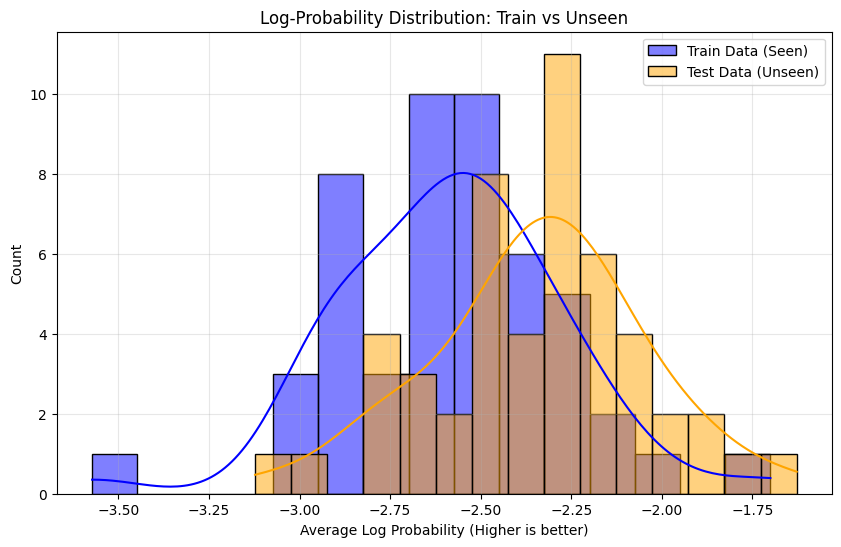

Average LogProb (Train):  -2.5833
Average LogProb (Unseen): -2.3427

⚠️ Вывод: Модель оценивает данные одинаково или Unseen выше.
Это значит, что сильного переобучения нет, либо данные очень похожи.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datasets import load_dataset

# 1. Функция анализа 
def get_log_prob_score(model, tokenizer, text):
    """
    Возвращает средний log_prob для текста.
    Чем выше значение (ближе к 0), тем вероятнее текст для модели.
    """
    # Токенизируем
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)

    with torch.no_grad():
        # Labels = input_ids заставляет модель считать лосс предсказания следующего токена
        outputs = model(**inputs, labels=inputs.input_ids)

    # loss = -mean(log_prob), поэтому возвращаем -loss
    return -outputs.loss.item()

# 2. Подготовка данных
# Загрузим "сырой" датасет заново, чтобы взять тексты
full_dataset = load_dataset(DATASET_ID, split="train")

# --- Группа 1: Train (то, на чем учили) ---
# Мы брали первые N примеров. Возьмем 50 штук из начала.
train_subset = full_dataset.select(range(50))

# --- Группа 2: Unseen (то, что модель не видела) ---
# Возьмем 50 штук с конца датасета (мы их обрезали при обучении)
# на одном домене (DPO dataset) честнее показывает переобучение.
unseen_subset = full_dataset.select(range(len(full_dataset) - 50, len(full_dataset)))

# 3. Сбор статистики
train_scores = []
unseen_scores = []

print("Analyzing Train Data...")
for example in tqdm(train_subset, desc="Train"):
    # Формируем полный текст диалога (Prompt + Chosen Response)
    # Нам интересно, насколько вероятен "правильный" диалог
    messages = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["chosen"]}
    ]
    # Применяем шаблон (как при обучении)
    text = tokenizer.apply_chat_template(messages, tokenize=False)

    score = get_log_prob_score(model, tokenizer, text)
    train_scores.append(score)

print("Analyzing Unseen Data...")
for example in tqdm(unseen_subset, desc="Unseen"):
    messages = [
        {"role": "user", "content": example["prompt"]},
        {"role": "assistant", "content": example["chosen"]}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False)

    score = get_log_prob_score(model, tokenizer, text)
    unseen_scores.append(score)

# 4. Визуализация и Выводы
plt.figure(figsize=(10, 6))

# Рисуем гистограммы
sns.histplot(train_scores, color="blue", label="Train Data (Seen)", kde=True, alpha=0.5, bins=15)
sns.histplot(unseen_scores, color="orange", label="Test Data (Unseen)", kde=True, alpha=0.5, bins=15)

plt.title("Log-Probability Distribution: Train vs Unseen")
plt.xlabel("Average Log Probability (Higher is better)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Текстовый вывод
avg_train = np.mean(train_scores)
avg_unseen = np.mean(unseen_scores)

print(f"Average LogProb (Train):  {avg_train:.4f}")
print(f"Average LogProb (Unseen): {avg_unseen:.4f}")

if avg_train > avg_unseen:
    print("\n✅ Вывод: Модель считает обучающие данные более вероятными (ожидаемое поведение).")
    print("Это может указывать на то, что модель 'запомнила' паттерны из обучения.")
else:
    print("\n⚠️ Вывод: Модель оценивает данные одинаково или Unseen выше.")
    print("Это значит, что сильного переобучения нет, либо данные очень похожи.")

# Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Оформить репозитории на 🤗 (можно сделать коллекцию, так как у нас 3 репозитория): карточка модели с описанием задания, репортом качества и примерами генерации **[1 балл]**

# Специальный раздел для проверяющего

In [32]:
device = torch.device("cuda")

DPO_REPO_NAME = f"{REPO_NAME}-dpo"
PPO_REPO_NAME = f"{REPO_NAME}-ppo"
REWARD_MODEL_REPO_NAME = f"{REPO_NAME}-reward-model"

tokenizer = AutoTokenizer.from_pretrained(DPO_REPO_NAME)
check_model = AutoModelForCausalLM.from_pretrained(DPO_REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/196 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/272 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

In [33]:
messages = [{"role": "user", "content": "What's your morning routine like?"}]

text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

generated_ids = check_model.generate(model_inputs.input_ids, max_new_tokens=256, do_sample=False)
response = tokenizer.decode(generated_ids, skip_special_tokens=True)[0]